<a href="https://colab.research.google.com/github/jinyoungkim0214/mnist-classifier/blob/main/mnist_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np #수학연산
import pandas as pd #데이터처리

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import IPython.display as ipd

In [ ]:
glob.glob('./**/*mnist*.*')
['./sample_data/mnist_test.csv', './sample_data/mnist_train_small.csv']

['./sample_data/mnist_test.csv', './sample_data/mnist_train_small.csv']

In [ ]:
df = pd.read_csv('./sample_data/mnist_train_small.csv')
df_test = pd.read_csv('./sample_data/mnist_test.csv')
print(df.shape, df_test.shape)

(19999, 785) (9999, 785)


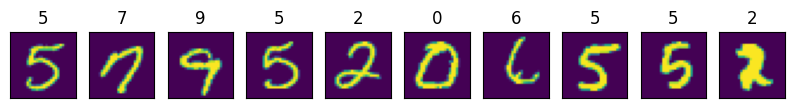

In [ ]:
def imshowTen(imgs,labels): #
    fig,axs = plt.subplots(1,10, figsize=(10,2))
    for i, ax in enumerate(axs.flat):
        ax.imshow(imgs.reshape(-1,28,28,1)[i])
        ax.set_title(f"{labels[i]}")
        ax.set_xticks([])
        ax.set_yticks([])

data = df.iloc[:10, 1:].to_numpy()
labels = df.iloc[:10, 0].to_numpy()
imgs = data.reshape(-1,28,28,1)
imshowTen(imgs,labels)

In [ ]:
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T

class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __getitem__(self, idx):
        try:
            img = self.df.iloc[idx,1:].to_numpy().reshape(1,28,28)
            img = torch.tensor(img/ 255.0, dtype=torch.float)
            label = torch.tensor(self.df.iloc[idx, 0])
            return img, label
        except Exception as e:
            print("error! : ", e)
            img = self.df.iloc[0,1:].to_numpy().reshape(1,28,28)
            img = torch.tensor(img/ 255.0, dtype=torch.float)
            label = torch.tensor(self.df.iloc[0, 0])
            return img, label

    def __len__(self):
        return len(self.df)


In [ ]:
n_batch = 128

train_ds = CustomDataset(df)
train_dl = DataLoader(train_ds, batch_size=n_batch, shuffle=True, num_workers=2)

test_ds = CustomDataset(df_test)
test_dl = DataLoader(test_ds, batch_size=n_batch, shuffle=False, num_workers=2)

In [ ]:
imgs, labels = next(iter(train_dl))
print(imgs.shape, labels.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


In [ ]:
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(5408,10),
        )
    def forward(self, x):
        x  = self.model(x)
        return x

In [ ]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

clf = Classifier()
clf = clf.to(dev)
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(dev)

optim = torch.optim.Adam(clf.parameters(), lr=0.001)

In [ ]:
imgs, labels = next(iter(train_dl))
m = nn.Sequential(
    nn.Conv2d(1, 32, 3),#no batchnorm is best
    nn.MaxPool2d(2),
    nn.Flatten(),
)
out = m(imgs)
out.shape

torch.Size([128, 5408])

In [ ]:
def acc_fn(y_pred, y_true):
    accuracy = torch.eq(y_pred, y_true).sum().item()/len(y_pred)
    return accuracy

In [ ]:
def train_fn(model, dl, optim, loss_fn, acc_fn): #dl_학습데이터
    t_loss, t_acc = 0, 0
    model.train()
    for batch, (x,y) in enumerate(dl):
        x,y = x.to(dev), y.to(dev)

        y_logits = model(x).to(dev)
        y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1).to(dev)

        loss = loss_fn(y_logits, y)
        acc = acc_fn(y_preds, y)

        optim.zero_grad() #초기화
        loss.backward() #역전파
        optim.step()

        t_loss += loss
        t_acc += acc

    t_loss /= len(dl)
    t_acc /= len(dl) #평균
    return(t_loss, t_acc)

In [ ]:
def eval_fn(model, dl, loss_fn, acc_fn): #dl_testdata
    e_loss, e_acc = 0, 0
    with torch.inference_mode():
        for batch, (x,y) in enumerate(dl):
            x, y = x.to(dev), y.to(dev)

            y_logits = model(x).to(dev)
            y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1).to(dev)

            loss = loss_fn(y_logits, y)
            acc = acc_fn(y_preds, y)

            e_loss += loss.item()
            e_acc += acc

        e_loss /= len(dl)
        e_acc /= len(dl)
    return e_loss, e_acc

In [ ]:
from sklearn.model_selection import KFold #Nfold교차검증인데이름만다름
from torch.optim.lr_scheduler import ReduceLROnPlateau #진폭줄이기

lr_s = ReduceLROnPlateau(optim, mode='min', patience=4,
                         verbose=1, factor=0.2) #0.001*0.2

kfold = KFold(n_splits=5, shuffle=True, random_state=42) #가로쪼개기
trn_loss,trn_acc = [],[]
val_loss,val_acc = [],[]

for i, (trn_idx,val_idx) in enumerate(kfold.split(train_ds)):
    print(f"Fold {i}")
    min_val_loss = 2
    n_patience = 0

    trn_ds = Subset(train_ds, trn_idx)
    val_ds = Subset(train_ds, val_idx)
    trn_dl = DataLoader(trn_ds, batch_size=n_batch, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=n_batch, shuffle=False)

    for epoch in range(1):
        trn_l, trn_a = train_fn(clf, trn_dl, optim, loss_fn, acc_fn)
        val_l, val_a = eval_fn(clf, val_dl, loss_fn, acc_fn)

        if np.round(min_val_loss, 5) > np.round(val_l, 5) :
            min_val_loss = val_l
            n_patience = 0
            print(f'epoch {epoch}: Save the best params with val_loss:{val_l:.4f}, val_acc:{val_a:.4f}')
            torch.save(clf.state_dict(), f'./best_w_{i}.pth')
        else:
            n_patience += 1

        lr_s.step(val_l)
        if n_patience > 7:
            print(f"Early Stopping at epoch{epoch}")
            break

    trn_loss.append(trn_l)
    trn_acc.append(trn_a)
    val_loss.append(val_l)
    val_acc.append(val_a)
    #print(f"\t Train loss {np.mean(trn_loss):.4f} | acc {np.mean(trn_acc):.4f}")
    #print(f"\t Valid loss {np.mean(val_loss):.4f} | acc {np.mean(val_acc):.4f}")

Fold 0
epoch 0: Save the best params with val_loss:0.2299, val_acc:0.9360
Fold 1
epoch 0: Save the best params with val_loss:0.1786, val_acc:0.9495
Fold 2
epoch 0: Save the best params with val_loss:0.1351, val_acc:0.9614
Fold 3
epoch 0: Save the best params with val_loss:0.1299, val_acc:0.9639
Fold 4
epoch 0: Save the best params with val_loss:0.1173, val_acc:0.9697


In [ ]:
test_loss, test_acc = [],[]
for i in range(5):
    clf.load_state_dict(torch.load(f'best_w_{i}.pth'))
    loss, acc = eval_fn(clf, test_dl, loss_fn, acc_fn)
    test_loss.append(loss)
    test_acc.append(acc)

print(f"Average  loss {np.mean(test_loss):.4f} | acc {np.mean(test_acc):.4f}")
print(f"Variance loss {np.var(test_loss):.4f} | acc {np.var(test_acc):.4f}")

Average  loss 0.1663 | acc 0.9521
Variance loss 0.0007 | acc 0.0001
